# Data Preprocessing for Image Colorization

This notebook handles:
- Converting RGB images to LAB color space
- Creating train/validation/test splits
- Preprocessing images for model training
- Saving processed datasets

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from PIL import Image
import shutil
from tqdm import tqdm
import yaml
from skimage import color
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
from data_preprocessing import DataPreprocessor, ColorDataset, split_dataset
from utils import create_dataset_splits, setup_project_directories

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Setup and Configuration

In [2]:
# Load configuration
config_path = "../config/config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"Input size: {config['data']['input_size']}")
print(f"Batch size: {config['data']['batch_size']}")
print(f"Color space: {config['data']['color_space']}")

# Setup directories
data_root = "../data"
raw_dir = os.path.join(data_root, "raw")
processed_dir = os.path.join(data_root, "processed")

# Ensure directories exist
os.makedirs(processed_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(processed_dir, split), exist_ok=True)

print(f"Raw data directory: {raw_dir}")
print(f"Processed data directory: {processed_dir}")

Configuration loaded:
Input size: [256, 256]
Batch size: 16
Color space: LAB
Raw data directory: ../data\raw
Processed data directory: ../data\processed


## 2. Create Train/Val/Test Splits

In [3]:
# Check if we need to create splits
raw_train_dir = os.path.join(raw_dir, "train")
raw_val_dir = os.path.join(raw_dir, "val")
raw_test_dir = os.path.join(raw_dir, "test")

# Count existing images
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) 
               if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])

train_count = count_images(raw_train_dir)
val_count = count_images(raw_val_dir)
test_count = count_images(raw_test_dir)

print(f"Current raw data counts:")
print(f"Train: {train_count}")
print(f"Val: {val_count}")
print(f"Test: {test_count}")

# If no splits exist, create them from a single directory
if train_count == 0 and val_count == 0 and test_count == 0:
    # Check if there are images directly in raw directory
    raw_images = count_images(raw_dir)
    if raw_images > 0:
        print(f"\nFound {raw_images} images in raw directory. Creating splits...")
        
        # Create splits
        split_info = create_dataset_splits(
            raw_dir,
            raw_dir,  # Output to same directory structure
            train_ratio=config['data']['train_split'],
            val_ratio=config['data']['val_split'],
            test_ratio=config['data']['test_split']
        )
        
        print("Dataset splits created successfully!")
        print(split_info)
    else:
        print("\n⚠️  No images found in raw directory!")
        print("Please add images to ../data/raw/ first.")
        print("You can:")
        print("1. Copy images directly to ../data/raw/")
        print("2. Or create train/val/test subdirectories manually")

Current raw data counts:
Train: 9
Val: 9
Test: 9


## 3. Preview Raw Data

Sample Training Images:


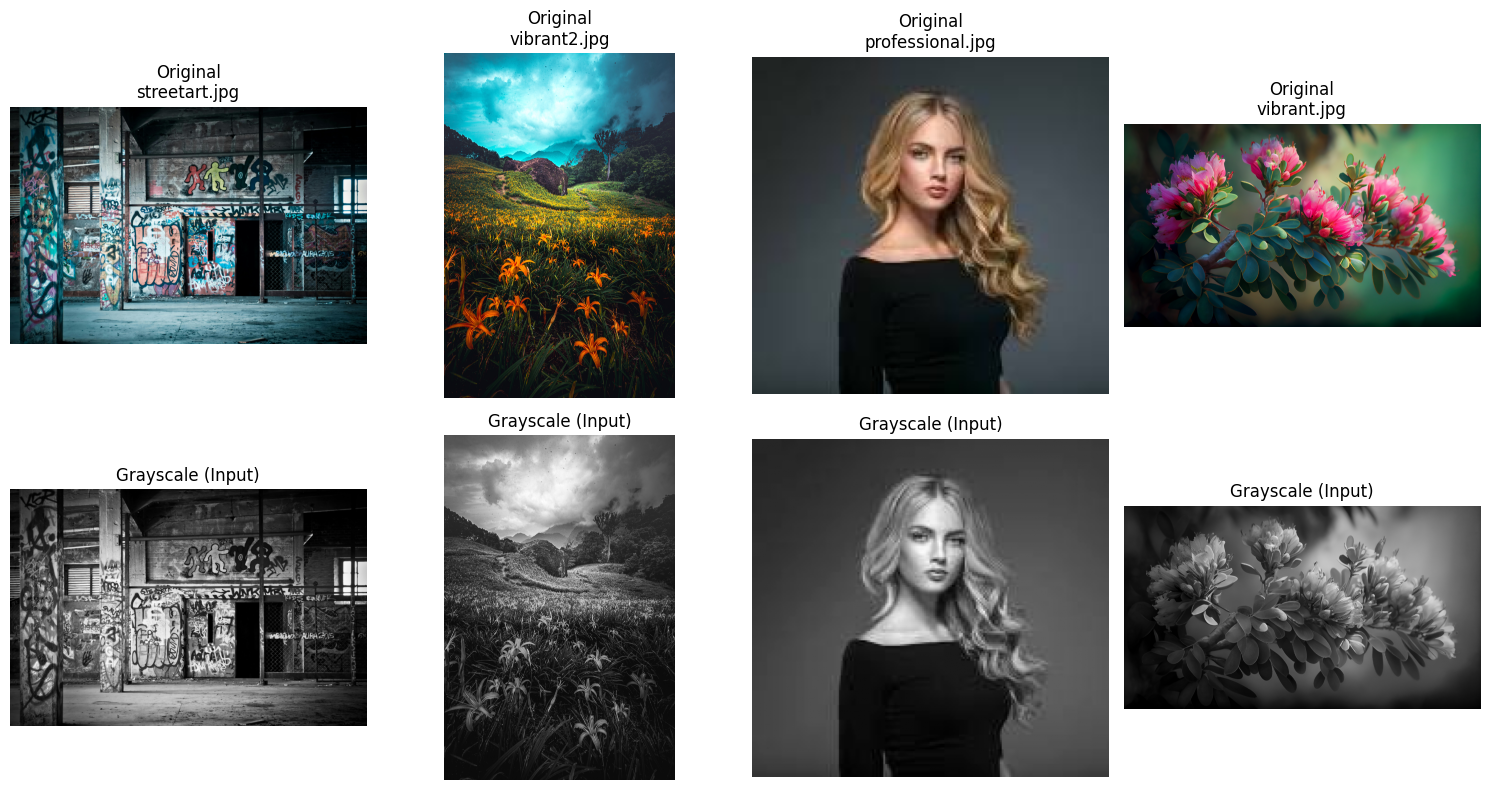

In [4]:
# Show sample raw images
def show_raw_samples(directory, num_samples=4):
    """Display sample images from raw directory."""
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist")
        return
    
    image_files = [f for f in os.listdir(directory) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if len(image_files) == 0:
        print(f"No images found in {directory}")
        return
    
    # Select random samples
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, len(selected_files), figsize=(15, 8))
    if len(selected_files) == 1:
        axes = axes.reshape(2, 1)
    
    for i, filename in enumerate(selected_files):
        img_path = os.path.join(directory, filename)
        
        try:
            # Load original image
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)
            
            # Show original
            axes[0, i].imshow(img_array)
            axes[0, i].set_title(f'Original\n{filename}')
            axes[0, i].axis('off')
            
            # Show grayscale version (what model will see as input)
            gray_img = img.convert('L')
            axes[1, i].imshow(gray_img, cmap='gray')
            axes[1, i].set_title(f'Grayscale (Input)')
            axes[1, i].axis('off')
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    plt.tight_layout()
    plt.show()

# Show samples from training data
if train_count > 0:
    print("Sample Training Images:")
    show_raw_samples(raw_train_dir)
else:
    print("No training images to preview")

## 4. LAB Color Space Conversion

LAB Color Space Conversion Demo:


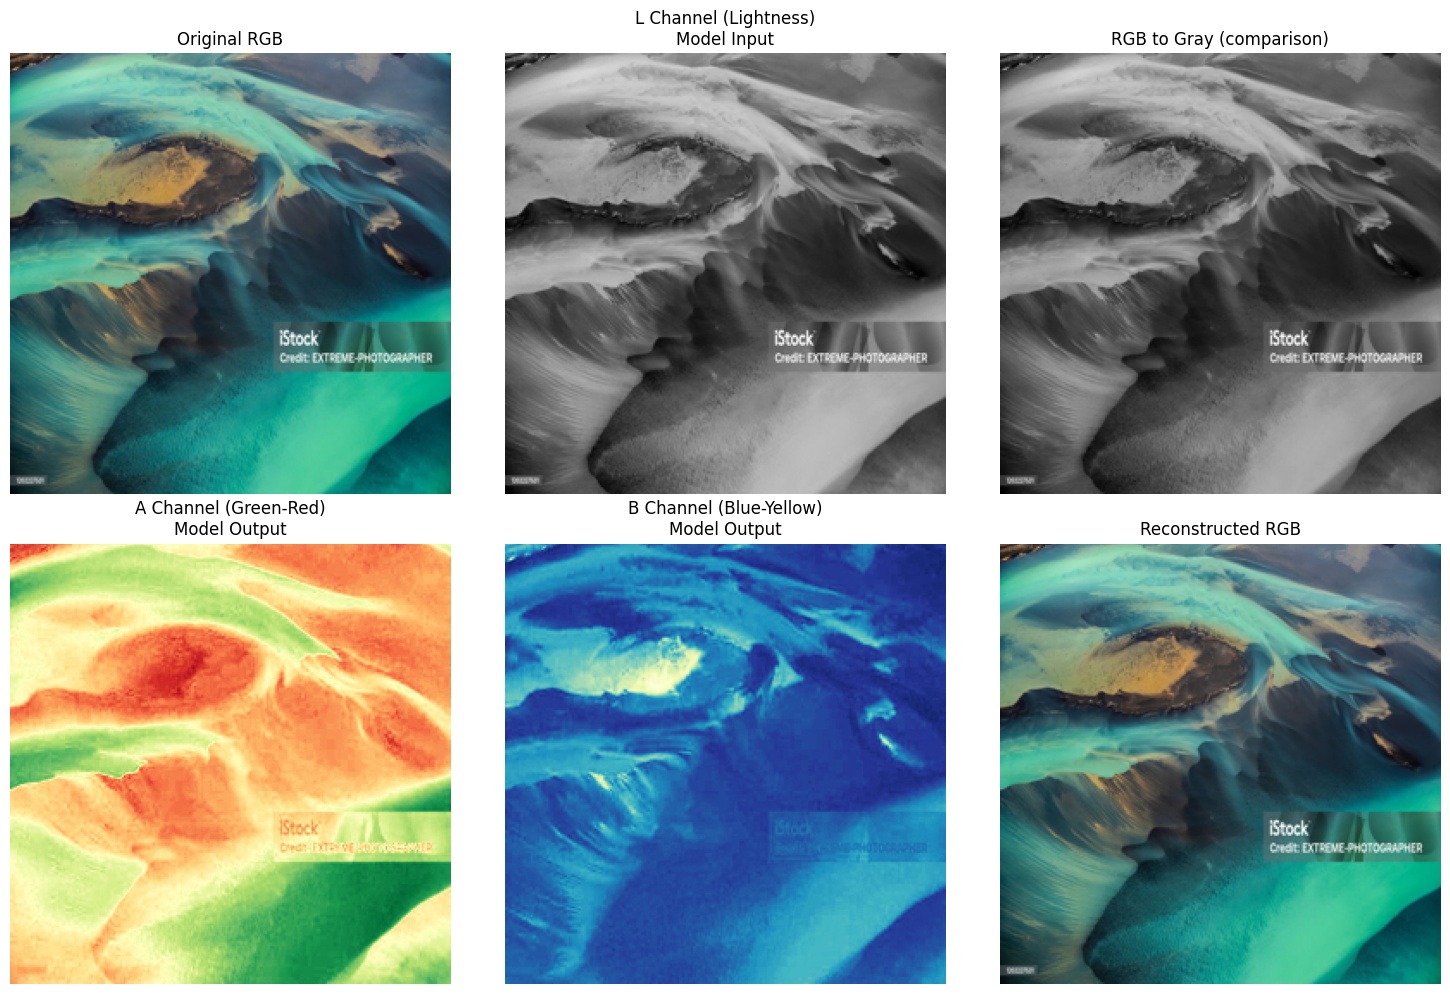

L channel range: 2.3 to 100.0
A channel range: -51.5 to 15.7
B channel range: -21.6 to 48.3


In [5]:
# Demonstrate LAB color space conversion
def demo_lab_conversion(image_path):
    """Demonstrate LAB color space conversion."""
    # Load image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((256, 256))  # Resize for consistency
    img_array = np.array(img)
    
    # Convert to LAB
    lab_image = color.rgb2lab(img_array)
    
    # Extract channels
    L = lab_image[:, :, 0]  # Lightness
    A = lab_image[:, :, 1]  # Green-Red
    B = lab_image[:, :, 2]  # Blue-Yellow
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title('Original RGB')
    axes[0, 0].axis('off')
    
    # L channel
    axes[0, 1].imshow(L, cmap='gray')
    axes[0, 1].set_title('L Channel (Lightness)\nModel Input')
    axes[0, 1].axis('off')
    
    # Grayscale comparison
    gray_simple = color.rgb2gray(img_array)
    axes[0, 2].imshow(gray_simple, cmap='gray')
    axes[0, 2].set_title('RGB to Gray (comparison)')
    axes[0, 2].axis('off')
    
    # A channel
    axes[1, 0].imshow(A, cmap='RdYlGn_r')
    axes[1, 0].set_title('A Channel (Green-Red)\nModel Output')
    axes[1, 0].axis('off')
    
    # B channel
    axes[1, 1].imshow(B, cmap='YlGnBu_r')
    axes[1, 1].set_title('B Channel (Blue-Yellow)\nModel Output')
    axes[1, 1].axis('off')
    
    # Reconstructed
    reconstructed = color.lab2rgb(lab_image)
    axes[1, 2].imshow(reconstructed)
    axes[1, 2].set_title('Reconstructed RGB')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"L channel range: {L.min():.1f} to {L.max():.1f}")
    print(f"A channel range: {A.min():.1f} to {A.max():.1f}")
    print(f"B channel range: {B.min():.1f} to {B.max():.1f}")

# Demo LAB conversion if we have images
if train_count > 0:
    sample_image = None
    for filename in os.listdir(raw_train_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            sample_image = os.path.join(raw_train_dir, filename)
            break
    
    if sample_image:
        print("LAB Color Space Conversion Demo:")
        demo_lab_conversion(sample_image)
else:
    print("No images available for LAB conversion demo")

## 5. Create Processed Dataset

In [6]:
# Process and copy images to processed directory
def process_dataset(input_dir, output_dir, target_size=(256, 256)):
    """Process raw images and save to processed directory."""
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist")
        return 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    image_files = [f for f in os.listdir(input_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if len(image_files) == 0:
        print(f"No images found in {input_dir}")
        return 0
    
    processed_count = 0
    errors = []
    
    print(f"Processing {len(image_files)} images from {input_dir}...")
    
    for filename in tqdm(image_files):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        try:
            # Load image
            with Image.open(input_path) as img:
                # Convert to RGB if necessary
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Resize to target size
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                
                # Save processed image
                img.save(output_path, 'PNG')  # Save as PNG to avoid compression artifacts
                
                processed_count += 1
                
        except Exception as e:
            errors.append((filename, str(e)))
            print(f"Error processing {filename}: {e}")
    
    print(f"Successfully processed {processed_count} images")
    if errors:
        print(f"Failed to process {len(errors)} images")
    
    return processed_count

# Process all splits
target_size = tuple(config['data']['input_size'])
print(f"Target image size: {target_size}")

total_processed = 0

# Process train
if train_count > 0:
    train_processed = process_dataset(
        raw_train_dir, 
        os.path.join(processed_dir, 'train'), 
        target_size
    )
    total_processed += train_processed

# Process validation
if val_count > 0:
    val_processed = process_dataset(
        raw_val_dir, 
        os.path.join(processed_dir, 'val'), 
        target_size
    )
    total_processed += val_processed

# Process test
if test_count > 0:
    test_processed = process_dataset(
        raw_test_dir, 
        os.path.join(processed_dir, 'test'), 
        target_size
    )
    total_processed += test_processed

print(f"\nTotal images processed: {total_processed}")

Target image size: (256, 256)
Processing 9 images from ../data\raw\train...


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.58it/s]


Successfully processed 9 images
Processing 9 images from ../data\raw\val...


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.92it/s]


Successfully processed 9 images
Processing 9 images from ../data\raw\test...


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.23it/s]

Successfully processed 9 images

Total images processed: 27


## 6. Test Data Loading

In [7]:
# Test the data loading pipeline
if total_processed > 0:
    print("Testing data loading pipeline...")
    
    # Initialize preprocessor
    preprocessor = DataPreprocessor(config_path)
    
    try:
        # Create data loaders
        train_loader, val_loader, test_loader = preprocessor.create_dataloaders(
            os.path.join(processed_dir, 'train'),
            os.path.join(processed_dir, 'val'),
            os.path.join(processed_dir, 'test')
        )
        
        print(f"✓ Data loaders created successfully!")
        print(f"  Train batches: {len(train_loader)}")
        print(f"  Val batches: {len(val_loader)}")
        if test_loader:
            print(f"  Test batches: {len(test_loader)}")
        
        # Test loading a batch
        print("\nTesting batch loading...")
        for L, AB, filenames in train_loader:
            print(f"✓ Successfully loaded batch:")
            print(f"  L channel shape: {L.shape}")
            print(f"  AB channels shape: {AB.shape}")
            print(f"  Batch size: {len(filenames)}")
            print(f"  Sample filenames: {filenames[:3]}")
            
            # Check value ranges
            print(f"  L channel range: [{L.min():.3f}, {L.max():.3f}]")
            print(f"  AB channels range: [{AB.min():.3f}, {AB.max():.3f}]")
            break
            
    except Exception as e:
        print(f"❌ Error creating data loaders: {e}")
        
else:
    print("No processed images available for testing")

INFO:data_preprocessing:Found 9 images in ../data\processed\train
INFO:data_preprocessing:Found 9 images in ../data\processed\val
INFO:data_preprocessing:Found 9 images in ../data\processed\test
INFO:data_preprocessing:Created data loaders:
INFO:data_preprocessing:  Train: 1 batches
INFO:data_preprocessing:  Val: 1 batches
INFO:data_preprocessing:  Test: 1 batches


Testing data loading pipeline...
✓ Data loaders created successfully!
  Train batches: 1
  Val batches: 1
  Test batches: 1

Testing batch loading...
✓ Successfully loaded batch:
  L channel shape: torch.Size([9, 1, 256, 256])
  AB channels shape: torch.Size([9, 2, 256, 256])
  Batch size: 9
  Sample filenames: ('restaurant.jpg', 'vibrant.jpg', 'vibrant2.jpg')
  L channel range: [-1.000, 1.000]
  AB channels range: [-0.549, 0.702]


## 7. Visualize Processed Data

Visualizing processed data samples...


TypeError: slice indices must be integers or None or have an __index__ method

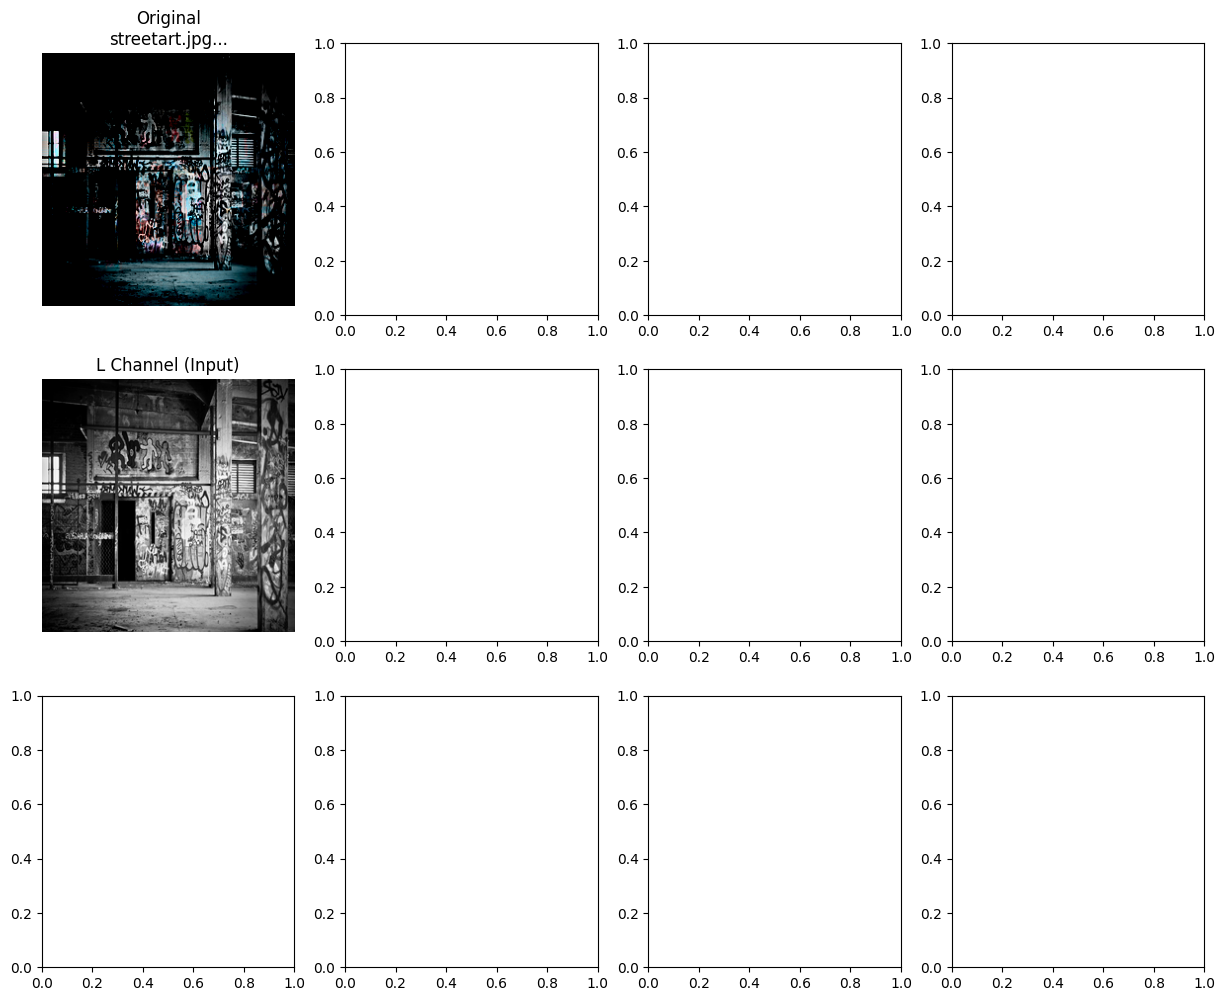

In [14]:
# Visualize processed data samples
if total_processed > 0 and 'train_loader' in locals():
    print("Visualizing processed data samples...")
    
    # Get a batch of data
    for L, AB, filenames in train_loader:
        # Take first 4 samples from batch
        num_samples = min(4, L.shape[0])
        
        fig, axes = plt.subplots(3, num_samples, figsize=(15, 12))
        if num_samples == 1:
            axes = axes.reshape(3, 1)
        
        for i in range(num_samples):
            # Convert back to RGB for visualization
            rgb_image = preprocessor.lab_to_rgb(
                L[i:i+1], AB[i:i+1]
            )[0]
            
            # Denormalize L channel for display
            L_display = (L[i, 0].numpy() + 1) / 2  # -1,1 -> 0,1
            
            # Original RGB
            axes[0, i].imshow(rgb_image)
            axes[0, i].set_title(f'Original\n{filenames[i][:15]}...')
            axes[0, i].axis('off')
            
            # L channel (model input)
            axes[1, i].imshow(L_display, cmap='gray')
            axes[1, i].set_title('L Channel (Input)')
            axes[1, i].axis('off')
            
            # AB channels visualization - FIXED VERSION
            AB_display = AB[i].numpy().transpose(1, 2, 0)  # CHW -> HWC
            # Create a proper visualization for AB channels
            AB_vis = np.zeros((AB_display.shape[0], AB_display.shape[asset:1], 3))  # FIXED: removed 'asset'
            AB_vis[:, :, 0] = (AB_display[:, :, 0] + 1) / 2  # A channel -> Red
            AB_vis[:, :, 1] = (AB_display[:, :, 1] + 1) / 2  # B channel -> Green
            AB_vis[:, :, 2] = 0.5  # Blue channel set to middle value
            axes[2, i].imshow(AB_vis)  # Now it's RGB format
            axes[2, i].set_title('AB Channels (A=Red, B=Green)')
            axes[2, i].axis('off')

        plt.tight_layout()
        plt.show()
        break
        
else:
    print("No data available for visualization")


## 8. Save Processing Summary

In [9]:
# Create processing summary
summary = {
    'preprocessing_completed': True,
    'target_size': target_size,
    'color_space': config['data']['color_space'],
    'processed_counts': {
        'train': count_images(os.path.join(processed_dir, 'train')),
        'val': count_images(os.path.join(processed_dir, 'val')),
        'test': count_images(os.path.join(processed_dir, 'test'))
    },
    'total_processed': total_processed,
    'data_splits': {
        'train_ratio': config['data']['train_split'],
        'val_ratio': config['data']['val_split'],
        'test_ratio': config['data']['test_split']
    }
}

# Save summary
summary_path = os.path.join(processed_dir, 'preprocessing_summary.yaml')
with open(summary_path, 'w') as f:
    yaml.dump(summary, f, default_flow_style=False)

print("Preprocessing Summary:")
print("=" * 40)
for key, value in summary.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")

print(f"\nSummary saved to: {summary_path}")

Preprocessing Summary:
preprocessing_completed: True
target_size: (256, 256)
color_space: LAB
processed_counts:
  train: 9
  val: 9
  test: 9
total_processed: 27
data_splits:
  train_ratio: 0.8
  val_ratio: 0.15
  test_ratio: 0.05

Summary saved to: ../data\processed\preprocessing_summary.yaml


## Next Steps

Your data has been preprocessed and is ready for training!

**What was done:**
1. ✅ Images resized to consistent size
2. ✅ RGB images converted to LAB color space
3. ✅ L channel prepared as model input (grayscale)
4. ✅ AB channels prepared as model target (color information)
5. ✅ Data loaders tested and working

**Next notebooks to run:**
1. `03_augmentation_experiments.ipynb` - Test different augmentation strategies
2. `04_model_training_baseline.ipynb` - Train baseline model without augmentation
3. `05_model_training_augmented.ipynb` - Train with data augmentation
4. `06_evaluation_comparison.ipynb` - Compare model performance

**Ready for training!** 🚀